# Домашнее задание
## Параллельные вычисления

Тема: "Решение задачи линейного программирования при помощи параллельного варианта симплекс-метода"

Выполнили:
- Зимин Григорий Сергеевич, ИУ8-112
- Александров Алексей Н., ИУ8-114
- Сакулин Даниил Игоревич, ИУ8-115

In [1]:
import logging
from pathlib import Path

import numpy as np
import cupy as cp

from src.simplex.simplex_problem import SimplexProblem, Solution

In [2]:
logging.basicConfig(
    level=logging.CRITICAL, 
    format='%(message)s',
)

In [3]:
sample_input_path = Path("sample_input_LLP.json")
problem = SimplexProblem(sample_input_path)

F = c⋅x -> max,
Ax <= b,
x1,x2, ..., xn >= 0
c^T = [-1 -1 -2],
A =
[[ 0  8 -6]
 [ 9  7  2]
 [ 2 -1  8]],
b^T = [1 2 3].
Используем <class 'src.simplex.simplex_table.base.BaseSimplexTable'> (GPU: None)


In [4]:
solution, _ = problem.solve()
solution

Процесс решения:
Поиск опорного решения: 
Исходная симплекс-таблица:
+----+--------+--------+---------+---------+
|    |  Si0   |   x1   |    x2   |    x3   |
+----+--------+--------+---------+---------+
| x4 | 1.0000 | 0.0000 |  8.0000 | -6.0000 |
| x5 | 2.0000 | 9.0000 |  7.0000 |  2.0000 |
| x6 | 3.0000 | 2.0000 | -1.0000 |  8.0000 |
| F  | 0.0000 | 1.0000 |  1.0000 |  2.0000 |
+----+--------+--------+---------+---------+
Опорное решение найдено!
x1 = x2 = x3 = 0, 
x4 = 1.000, x5 = 2.000, x6 = 3.000
Целевая функция: F = 0.000
Поиск оптимального решения:
Разрешающая строка: x5
Разрешающий столбец: x1
+----+---------+---------+---------+---------+
|    |   Si0   |    x5   |    x2   |    x3   |
+----+---------+---------+---------+---------+
| x4 |  1.0000 | -0.0000 |  8.0000 | -6.0000 |
| x1 |  0.2222 |  0.1111 |  0.7778 |  0.2222 |
| x6 |  2.5556 | -0.2222 | -2.5556 |  7.5556 |
| F  | -0.2222 | -0.1111 |  0.2222 |  1.7778 |
+----+---------+---------+---------+---------+
Разрешающая ст

([0, 0.17241379310344826, 0.396551724137931, 2.0, 0, 0], 0.9655172413793104)

In [5]:
problem = SimplexProblem(sample_input_path, use_gpu="cupy", verbose=False)

F = c⋅x -> max,
Ax <= b,
x1,x2, ..., xn >= 0
c^T = [-1 -1 -2],
A =
[[ 0  8 -6]
 [ 9  7  2]
 [ 2 -1  8]],
b^T = [1 2 3].
Используем <class 'src.simplex.simplex_table.gpu.cupy.CupySimplexTable'> (GPU: cupy)


In [6]:
solution, _ = problem.solve()
solution

Процесс решения:
Поиск опорного решения: 
Исходная симплекс-таблица:
+----+--------+--------+---------+---------+
|    |  Si0   |   x1   |    x2   |    x3   |
+----+--------+--------+---------+---------+
| x4 | 1.0000 | 0.0000 |  8.0000 | -6.0000 |
| x5 | 2.0000 | 9.0000 |  7.0000 |  2.0000 |
| x6 | 3.0000 | 2.0000 | -1.0000 |  8.0000 |
| F  | 0.0000 | 1.0000 |  1.0000 |  2.0000 |
+----+--------+--------+---------+---------+
Опорное решение найдено!
Поиск оптимального решения:
Разрешающая строка: x5
Разрешающий столбец: Si0
+----+--------+--------+---------+---------+
|    |  Si0   |   x5   |    x2   |    x3   |
+----+--------+--------+---------+---------+
| x4 | 1.0000 | 0.0000 |  8.0000 | -6.0000 |
| x1 | 2.0000 | 9.0000 |  7.0000 |  2.0000 |
| x6 | 3.0000 | 2.0000 | -1.0000 |  8.0000 |
| F  | 0.0000 | 1.0000 |  1.0000 |  2.0000 |
+----+--------+--------+---------+---------+
Разрешающая строка: x4
Разрешающий столбец: x5
+----+--------+--------+---------+---------+
|    |  Si0   |   

([0, 0.17241379310344826, 0.396551724137931, 2.0, 0, 0], 0.9655172413793104)

### Warming Up!

In [3]:
a_np = np.random.rand(10000, 10000)
b_np = np.random.rand(10000, 10000)

In [4]:
%%time
c = np.dot(a_np, b_np)
c

CPU times: user 2min 27s, sys: 28.7 s, total: 2min 56s
Wall time: 23.8 s


array([[2503.05203328, 2497.58268885, 2502.49436973, ..., 2509.53177621,
        2495.13160395, 2508.65600805],
       [2499.8794575 , 2489.43624986, 2485.73593552, ..., 2504.09559943,
        2484.74355645, 2498.9320086 ],
       [2501.55333184, 2507.0264505 , 2470.43360752, ..., 2501.08755247,
        2494.38430715, 2501.05105359],
       ...,
       [2491.7924914 , 2504.5345944 , 2485.46417788, ..., 2508.98059827,
        2484.45726014, 2489.92000876],
       [2524.42061904, 2528.99437749, 2528.15467425, ..., 2536.70662341,
        2512.27981757, 2539.03292542],
       [2494.59856895, 2483.53818292, 2482.91646738, ..., 2501.95256742,
        2469.39568289, 2484.35570517]])

In [5]:
%%time
a_cp = cp.asarray(a_np)
b_cp = cp.asarray(b_np)
c = cp.dot(a_cp, b_cp)
c

CPU times: user 436 ms, sys: 2.25 s, total: 2.68 s
Wall time: 2.48 s


array([[2503.05203328, 2497.58268885, 2502.49436973, ..., 2509.53177621,
        2495.13160395, 2508.65600805],
       [2499.8794575 , 2489.43624986, 2485.73593552, ..., 2504.09559943,
        2484.74355645, 2498.9320086 ],
       [2501.55333184, 2507.0264505 , 2470.43360752, ..., 2501.08755247,
        2494.38430715, 2501.05105359],
       ...,
       [2491.7924914 , 2504.5345944 , 2485.46417788, ..., 2508.98059827,
        2484.45726014, 2489.92000876],
       [2524.42061904, 2528.99437749, 2528.15467425, ..., 2536.70662341,
        2512.27981757, 2539.03292542],
       [2494.59856895, 2483.53818292, 2482.91646738, ..., 2501.95256742,
        2469.39568289, 2484.35570517]])

### Проведение бенчмарка

In [6]:
from src.benchmark import benchmark_lp_solver

increase_iter = (2, 5, 10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500)

report_table = benchmark_lp_solver(problem_size_iterable=increase_iter)
report_table

Processing problem with size: 2
  CPU completed: 0.839 ms
  GPU completed: 143.919 ms
  CPU and GPU have found equivalent solution: f = 0.736
Processing problem with size: 5
  CPU completed: 4.542 ms
  GPU completed: 8.159 ms
  CPU and GPU have found equivalent solution: f = 0.718
Processing problem with size: 10
  CPU completed: 13.451 ms
  GPU completed: 10.179 ms
  CPU and GPU have found equivalent solution: f = 0.109
Processing problem with size: 20
  CPU completed: 128.115 ms
  GPU completed: 34.592 ms
  CPU and GPU have found equivalent solution: f = 0.244
Processing problem with size: 40
  CPU completed: 196.702 ms
  GPU completed: 28.293 ms
  CPU and GPU have found equivalent solution: f = 0.056
Processing problem with size: 80
  CPU completed: 1774.478 ms
  GPU completed: 128.846 ms
  CPU and GPU have found equivalent solution: f = 0.037
Processing problem with size: 100
  CPU completed: 6653.290 ms
  GPU completed: 338.199 ms
  CPU and GPU have found equivalent solution: f = 

Размерность задачи (число переменных / ограничений),CPU Time (ms),GPU Time (ms),Прирост производительности
2,0.839,143.919,0.01
5,4.542,8.159,0.56
10,13.451,10.179,1.32
20,128.115,34.592,3.70
40,196.702,28.293,6.95
80,1774.478,128.846,13.77
100,6653.290,338.199,19.67
150,18827.919,624.872,30.13
200,16980.838,402.533,42.18
250,49942.830,945.806,52.80


In [7]:
import matplotlib.pyplot as plt

# Извлечение столбцов из таблицы для построения графиков
sizes = [int(row[0]) for row in report_table.rows]
cpu_times = [float(row[1]) for row in report_table.rows]
gpu_times = [float(row[2]) for row in report_table.rows]

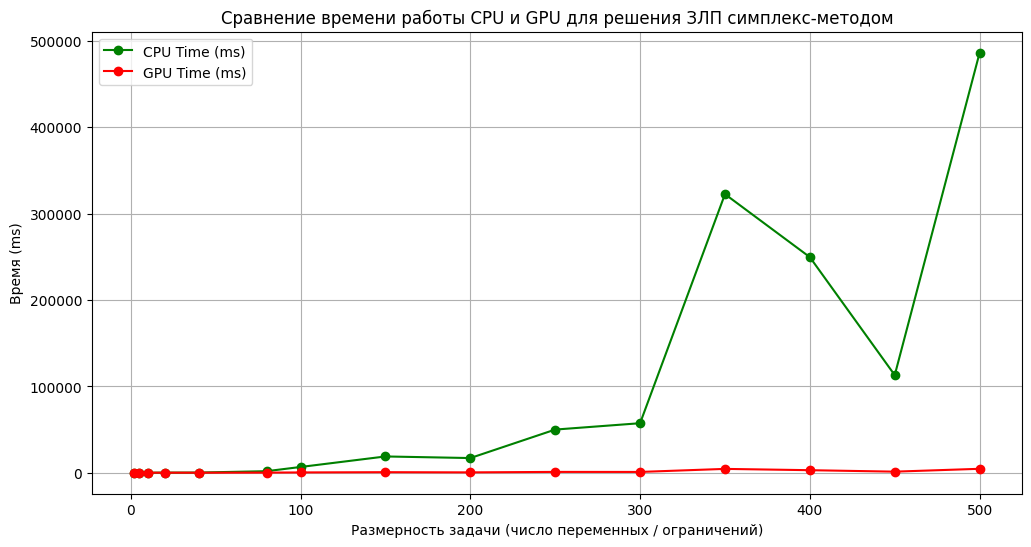

In [8]:
plt.figure(figsize=(12, 6))

# График времени работы CPU
plt.plot(sizes, cpu_times, label='CPU Time (ms)', marker='o', color='green')
# График времени работы GPU
plt.plot(sizes, gpu_times, label='GPU Time (ms)', marker='o', color='red')

plt.xlabel('Размерность задачи (число переменных / ограничений)')
plt.ylabel('Время (ms)')
plt.title('Сравнение времени работы CPU и GPU для решения ЗЛП симплекс-методом')
plt.legend()
plt.grid()
plt.show()

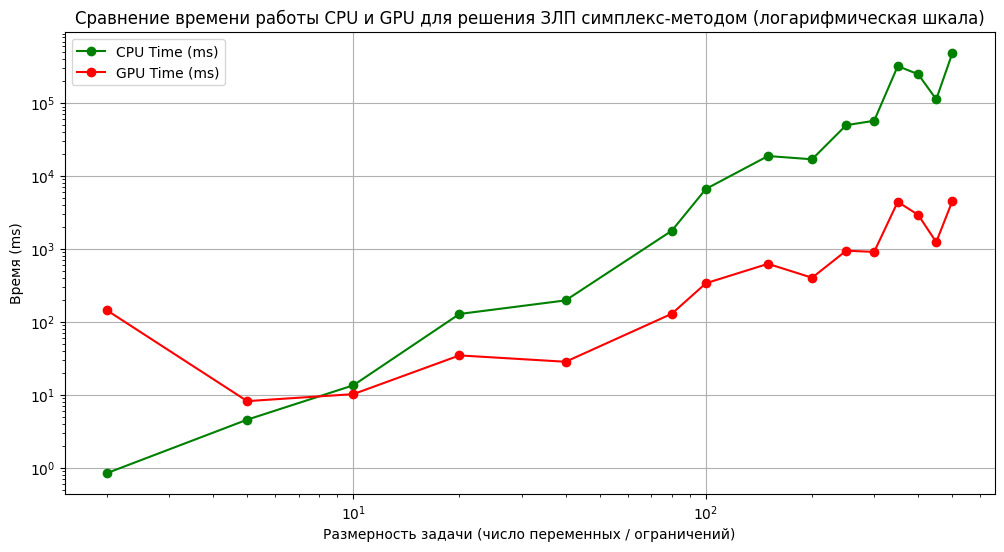

In [10]:
plt.figure(figsize=(12, 6))

# График времени работы CPU
plt.plot(sizes, cpu_times, label='CPU Time (ms)', marker='o', color='green')
# График времени работы GPU
plt.plot(sizes, gpu_times, label='GPU Time (ms)', marker='o', color='red')

plt.xlabel('Размерность задачи (число переменных / ограничений)')
plt.ylabel('Время (ms)')
plt.title('Сравнение времени работы CPU и GPU для решения ЗЛП симплекс-методом (логарифмическая шкала)')
plt.legend()
plt.grid()
# Логарифмическая шкала для лучшей визуализации
plt.xscale('log')  
plt.yscale('log')
plt.show()